In [1]:
expname   = "exp006_20250526_sna_kadirerdem"
modelname = "dev011_exp006_cnn.pth"

# WiFi analysis

In [2]:
import json
from matplotlib import pyplot as plt
import matplotlib.font_manager as font_manager
import numpy as np

json_file = "../experiments/"+expname+"/data-tshark/data.json"
with open(json_file) as f:
    data = json.load(f)

In [3]:
lo_uniqueSAs = []
lo_freqs     = []
lo_SActrs    = []
lo_SSIDs     = []
for pkt in data:
    if(pkt["_source"]["layers"]["wlan.sa"] not in lo_uniqueSAs):
        lo_uniqueSAs.append(pkt["_source"]["layers"]["wlan.sa"])
        lo_freqs.append(pkt["_source"]["layers"]["wlan_radio.frequency"][0])
        lo_SActrs.append(1)
        lo_SSIDs.append(pkt["_source"]["layers"]["wlan.ssid"][0])
    else:
        position_of_uniqueSA_in_listofuniqueSAs = lo_uniqueSAs.index(pkt["_source"]["layers"]["wlan.sa"])
        lo_SActrs[position_of_uniqueSA_in_listofuniqueSAs] += 1

In [4]:
print("SSID | Source Address    |  Freq |  # of occurrences")
print("-"*50)
selected_AP_idx = []
for i, ssid in enumerate(lo_SSIDs):
    #if ( ((ssid == "KU") and (lo_SActrs[i] > 1300)) or ("ekb_test" in ssid)):
    if ( ("ekb_test" in ssid) ):
        print(ssid, "  |", lo_uniqueSAs[i][0], "| ", lo_freqs[i], "| ", lo_SActrs[i])
        selected_AP_idx.append(i)

SSID | Source Address    |  Freq |  # of occurrences
--------------------------------------------------
ekb_test_vr400   | 50:c7:bf:19:e6:4d |  2412 |  5082
ekb_test_air5443   | 18:28:61:3d:94:7a |  2412 |  1892
ekb_test_vr600   | d8:47:32:eb:6c:38 |  2412 |  4974


In [5]:
data[4]

{'_index': 'packets-2025-05-26',
 '_type': 'doc',
 '_score': None,
 '_source': {'layers': {'frame.time': ['20:26:55.928'],
   'wlan_radio.signal_dbm': ['-85'],
   'wlan.sa': [],
   'wlan.ra': ['fe:5b:ae:e8:35:48'],
   'wlan.da': [],
   'wlan_radio.frequency': ['2412'],
   'wlan.ssid': [''],
   'loc_x': '0.32815844',
   'loc_y': '0.54506564'}}}

In [6]:
def frametime2secs(frametime):
    hrs   = int(frametime.split(":")[0])
    mins  = int(frametime.split(":")[1])
    secs  = int((frametime.split(":")[2]).split(".")[0])
    msecs = int((frametime.split(":")[2]).split(".")[1])
    total_seconds = (hrs*60*60*1000 + mins*60*1000 + secs*1000 + msecs) / 1000.0 
    return total_seconds

def get_timeinsecs(sampledict, offset=0):
    return frametime2secs(sampledict["_source"]["layers"]["frame.time"][0]) - offset;

def get_freq(sampledict):
    return sampledict["_source"]["layers"]["wlan_radio.frequency"][0]

def get_sourceaddr(sampledict):
    return sampledict["_source"]["layers"]["wlan.sa"]
    
def get_ssid(sampledict):
    return sampledict["_source"]["layers"]["wlan.ssid"][0]
    
def get_rss(sampledict):
    return sampledict["_source"]["layers"]["wlan_radio.signal_dbm"][0]

In [7]:
len(data)

109362

In [9]:
print(get_timeinsecs(data[4], offset=64999.800))
print(get_freq(data[4]))
print(get_sourceaddr(data[4]))
print(get_ssid(data[4]))
print(get_rss(data[4]))

8616.127999999997
2412
[]

-85


In [10]:
time = []
for sample in data:
    t = get_timeinsecs(sample, offset=64999.800)
    if(t not in time):
        time.append(t)

In [11]:
lo_uniqueSAs[selected_AP_idx[-1]]

['d8:47:32:eb:6c:38']

In [12]:
array_ssid_rss = np.zeros((len(time), len(selected_AP_idx)))*np.nan
for sample in data:
    t_sample  = get_timeinsecs(sample, offset=64999.800)
    t_idx     = time.index(t_sample)
    sa_sample = get_sourceaddr(sample)
    sa_idx    = lo_uniqueSAs.index(sa_sample)
    if(sa_idx in selected_AP_idx):
        array_ssid_idx = selected_AP_idx.index(sa_idx)
        array_ssid_rss[t_idx, array_ssid_idx] = get_rss(sample)

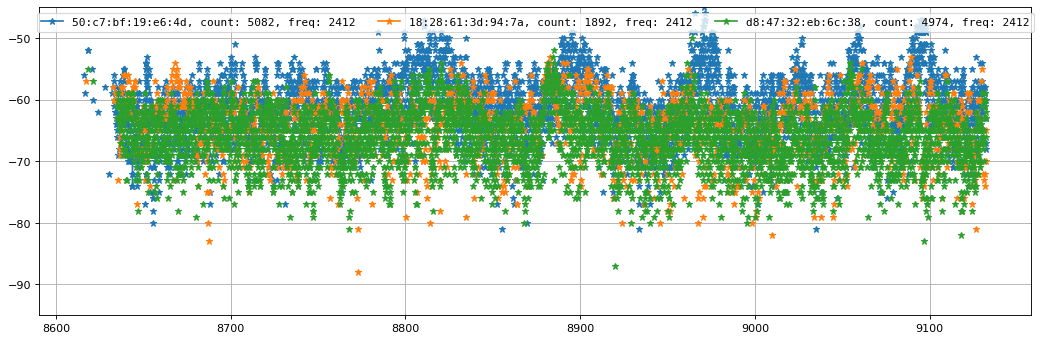

In [13]:
plt.figure(figsize=(16, 5), dpi=80)
plt.plot(time, array_ssid_rss, marker="*");
plt.ylim([-95, -45])
plt.grid()
plt.legend([(lo_uniqueSAs[idx][0]+ ", count: " + str(lo_SActrs[idx]) + ", freq: " + str(lo_freqs[idx])) for idx in selected_AP_idx], 
           prop=font_manager.FontProperties(family='monospace'), loc='upper center', ncol=3)

In [14]:
target_adresses = ["d8:47:32:eb:6c:38",
                    "50:c7:bf:19:e6:4d",
                    "18:28:61:3d:94:7a"]

# RSS-Loc Analysis

In [15]:
import matplotlib.pyplot as plt
from auxiliary import loadData_staticTargetAddrMatch

In [16]:
datajsonpath = "../experiments/"+expname+"/data-tshark/data.json"
inp_rss_vals, gt_locations = loadData_staticTargetAddrMatch(datajsonpath, second_hold = 5, shuffle=False, 
                                                            target_addresses= target_adresses, snap250ms=False)

In [17]:
N=50
filtered_rss = np.asarray([np.convolve(inp_rss_vals[:,0], np.ones(N)/N, mode='same'),
                           np.convolve(inp_rss_vals[:,1], np.ones(N)/N, mode='same'),
                           np.convolve(inp_rss_vals[:,2], np.ones(N)/N, mode='same')])
filtered_rss = np.swapaxes(filtered_rss,0,1)

In [18]:
def plotXY(gt_locations, gt_range):
    plt.ylim([-5, 0])
    plt.xlim([0,5])
    plt.grid()
    plt.plot(gt_locations[gt_range,0], -1*gt_locations[gt_range,1])

In [19]:
def plotRSS(target_adresses, inp_rss_vals, gt_range):
    fig, axs = plt.subplots(3, 1, figsize=(15, 10))
    
    # Titles for the subplots
    titles = target_adresses
    
    # Loop through the 3 columns (0, 1, 2) to create subplots
    for i in range(3):
        # Plot the RSS values for the given limit in each subplot
        axs[i].plot(gt_range, inp_rss_vals[gt_range, i], color="blue", label="RSS values")
        
        # Calculate the mean of the RSS values
        mean_value = np.mean(inp_rss_vals[gt_range, i])
        
        # Plot the mean as a horizontal line
        axs[i].axhline(y=mean_value, color="red", linestyle="--", label=f"Mean = {mean_value:.2f}")
        
        # Set title, labels, and legend for each subplot
        axs[i].set_title(titles[i])
        axs[i].set_xlabel("Sample Index")
        axs[i].set_ylabel("RSS Value")
        axs[i].legend()
    
    # Adjust layout for better spacing between plots
    plt.tight_layout()
    
    # Display the figure with all subplots
    plt.show()

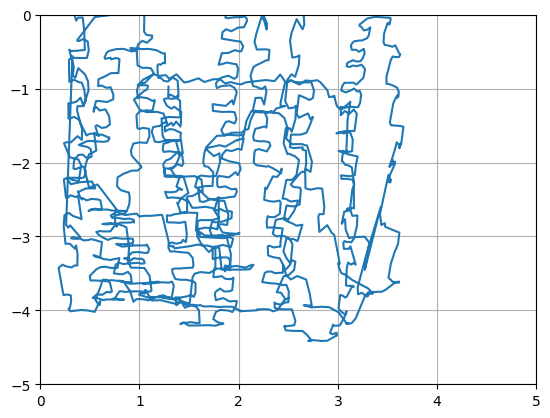

In [20]:
limits = range(0,len(gt_locations))
plotXY(gt_locations, limits)

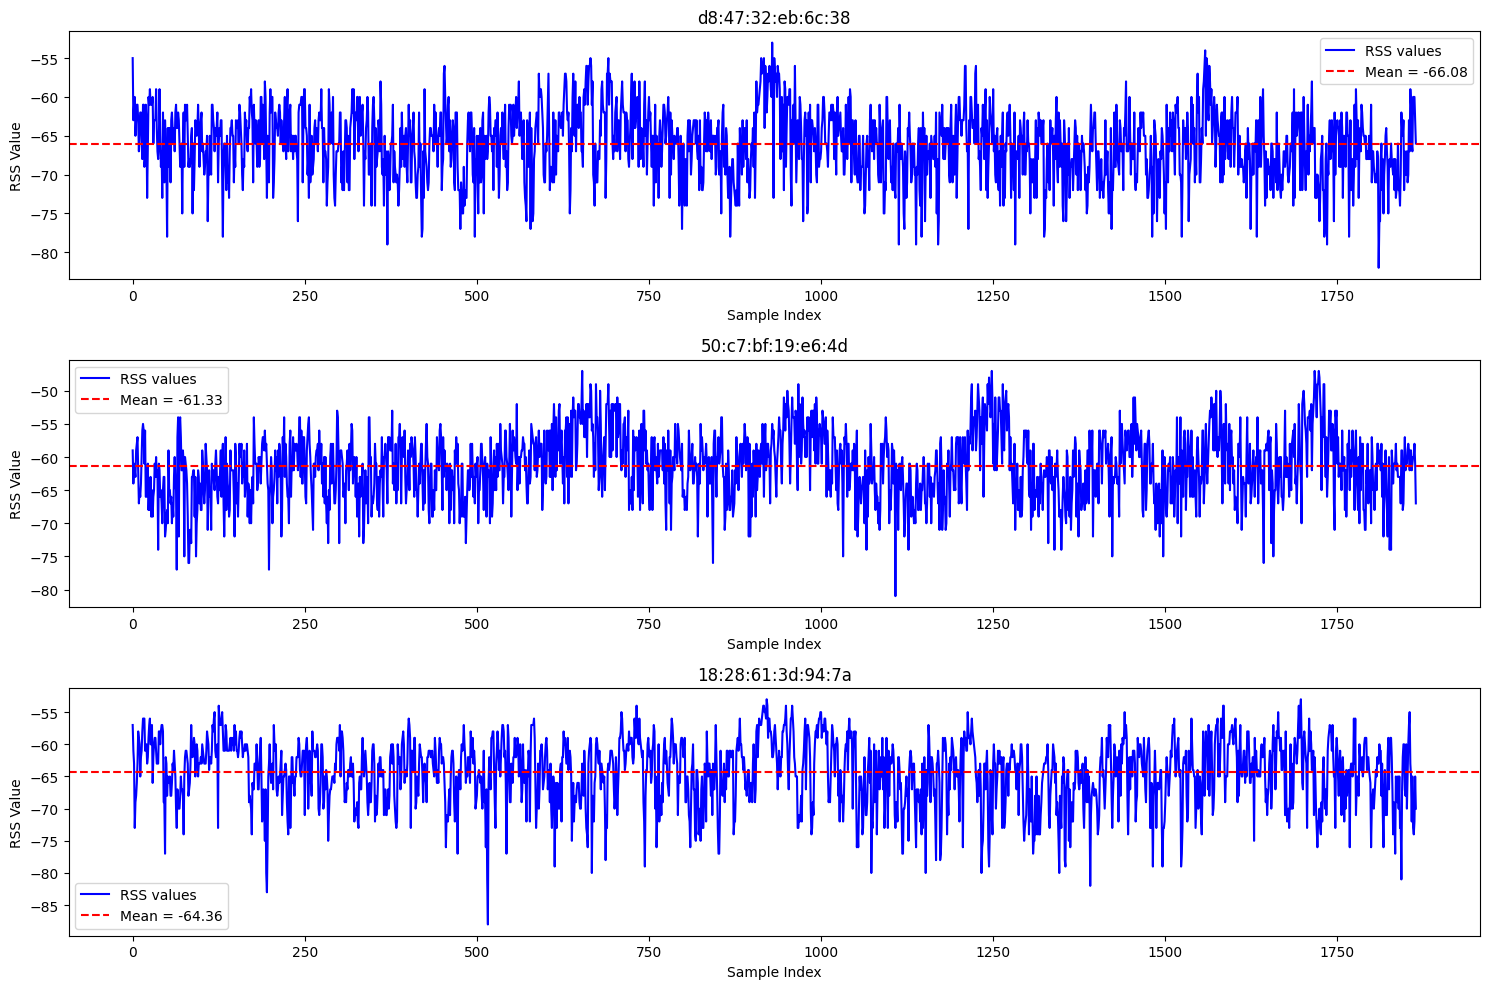

In [21]:
plotRSS(target_adresses, inp_rss_vals, limits)

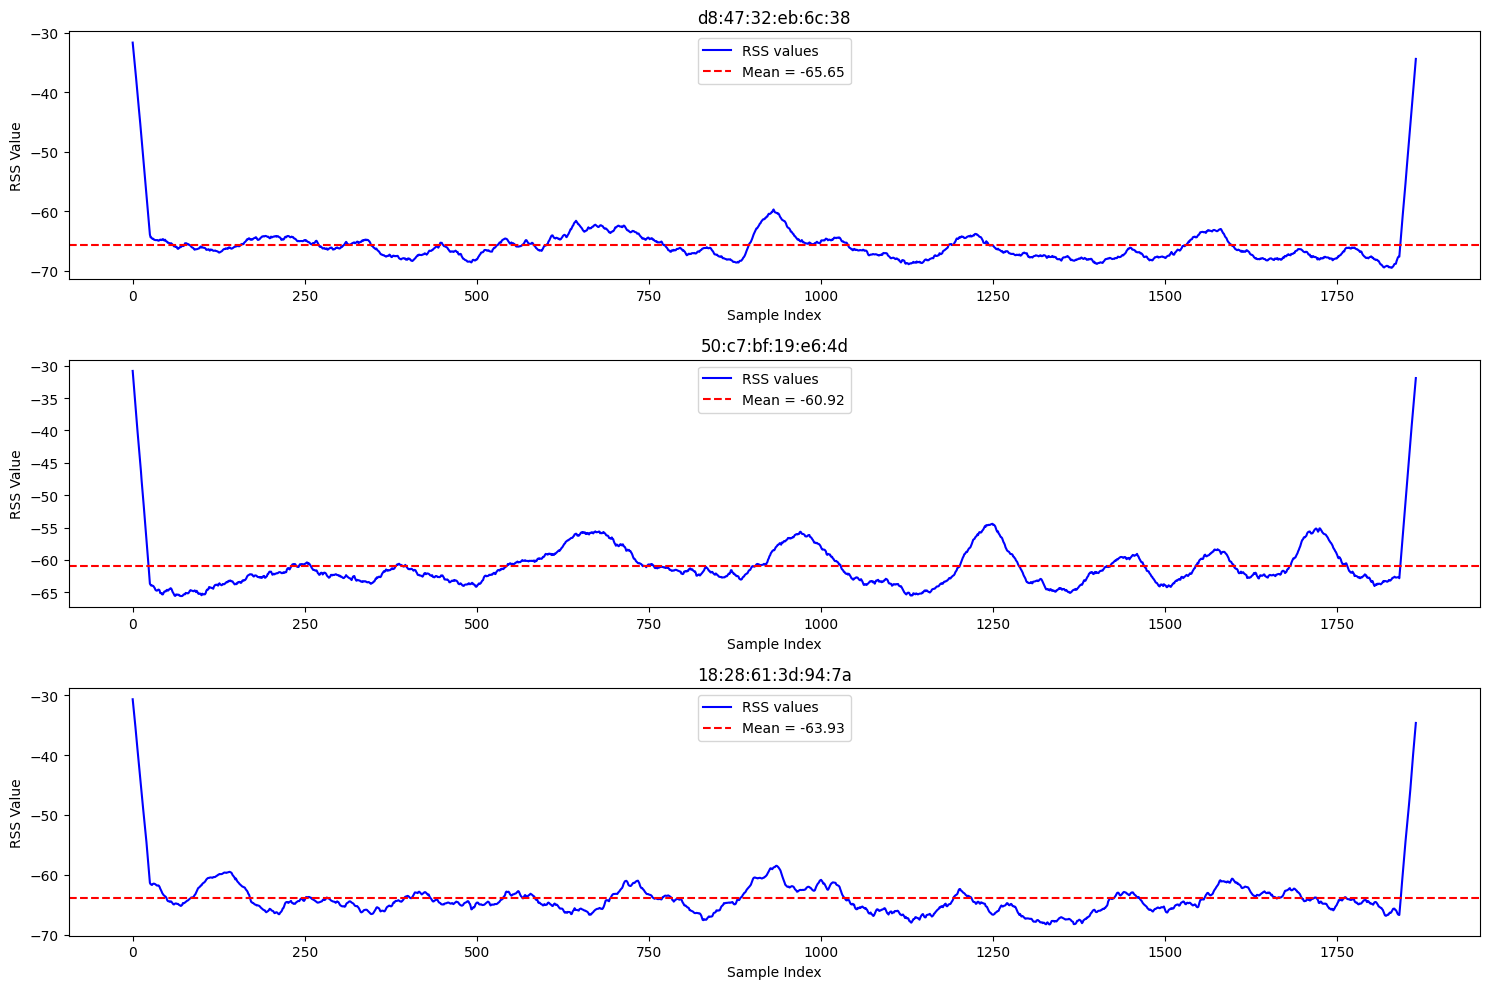

In [22]:
plotRSS(target_adresses, filtered_rss, limits)

# Modeling analysis

### prepare model, dataloaders and training parameters

In [23]:
from auxiliary import loadData_staticTargetAddrMatch, prepare_data_loaders
from algorithms import RssPosAlgo_NeuralNet_CNNv1
from algorithms import RssPosAlgo_NeuralNet_supervisedTrainingLoop
from algorithms import RssPosAlgo_NearestNeighbour
from algorithms import RssPosAlgo_NearestNeighbour_Interpolation
from algorithms import RssPosAlgo_NearestNeighbour_GetKmeansDb
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [24]:
datajsonpath = "../experiments/"+expname+"/data-tshark/data.json"
inp_rss_vals, gt_locations = loadData_staticTargetAddrMatch(datajsonpath, second_hold = 5, shuffle=False, 
                                                            target_addresses=target_adresses, snap250ms=False)

epochs           = 101
batch_size       = 64
train_test_split = 0.8
kernel_sizes     = [13, 9, 5, 3]  # Changed from single kernelsize to list
window_size      = 50

train_loader, test_loader, xtr, ytr, xts, yts = prepare_data_loaders(inp_rss_vals, gt_locations, 
                                                                     batch_size = batch_size, window_size=window_size,
                                                                     train_test_split = train_test_split,
                                                                     cnn_data=True, cnn_kernel_sizes=kernel_sizes)  # Changed parameter name and value

print("Subset sizes | train:", xtr.shape, ", test:",xts.shape)
cnn = RssPosAlgo_NeuralNet_CNNv1([8, 16, 8, 2], kernel_sizes)
cnn.train()
cnn.cuda()
cnn.device="cuda"

cnn_criterion = nn.MSELoss(reduction='mean')
cnn_optimizer = optim.Adam(cnn.parameters(), lr=1e-3, weight_decay=1e-4)

Subset sizes | train: torch.Size([1492, 3]) , test: torch.Size([373, 3])


In [25]:
for dat in train_loader:
    print(dat[1].shape)
    break

torch.Size([64, 2, 24])


### train model

In [26]:
sum(p.numel() for p in cnn.parameters() if p.requires_grad)

2186

In [27]:
cnn = RssPosAlgo_NeuralNet_supervisedTrainingLoop(train_loader = train_loader, 
                                                  test_loader  = test_loader,
                                                  model        = cnn, 
                                                  criterion    = cnn_criterion, 
                                                  optimizer    = cnn_optimizer, 
                                                  epochs       = epochs,
                                                  testfreq     = 20) # testfreq is in epochs

Epoch [1/101] test loss: 5.074, training loss: -1.000
Epoch [21/101] test loss: 0.900, training loss: 1.214
Epoch [41/101] test loss: 0.949, training loss: 1.113
Epoch [61/101] test loss: 0.792, training loss: 1.062
Epoch [81/101] test loss: 0.697, training loss: 1.067
Epoch [101/101] test loss: 0.743, training loss: 1.018


### save the model

In [28]:
torch.save(cnn.state_dict(), 'savedmodels/'+modelname)

### evaluate model vs interp

In [29]:
cnn = RssPosAlgo_NeuralNet_CNNv1([8, 16, 8, 2], kernel_sizes)
cnn.load_state_dict(torch.load('savedmodels/'+modelname));
cnn.eval();

In [30]:
error = 0  # Initialize the error accumulator
for test_inputs, test_labels in test_loader:
    loc_pred_cnn = cnn(test_inputs)
    loc_pred_cnn_np = loc_pred_cnn.detach().numpy()  # Predicted values
    yts_batch_np = test_labels.detach().numpy()  # True values
    diff = yts_batch_np - loc_pred_cnn_np
    error1 = 0
    for i in range(diff.shape[-1]):
        error1 += np.linalg.norm(diff[:,:,i])
    error += error1/diff.shape[-1]

print("Mean error:", error/len(test_loader))

Mean error: 1.088740357204528


In [31]:
num_clusterss = [3,4,5,7,9,11,13]
for num_clusters in num_clusterss:
    print("-"*20)
    print("# of clusters:", num_clusters)
    db_kmeans = RssPosAlgo_NearestNeighbour_GetKmeansDb(xtr, ytr, num_clusters=num_clusters)
    meanerror_nene_interp = 0;
    meanerror_nene        = 0;
    for test_idx, x_test_sample in enumerate(xts): 
        loc_pred_nene          = RssPosAlgo_NearestNeighbour(x_test_sample, db_kmeans)
        loc_pred_nene_interp   = RssPosAlgo_NearestNeighbour_Interpolation(x_test_sample, db_kmeans)
        meanerror_nene        += (yts[test_idx].numpy() - loc_pred_nene)**2
        meanerror_nene_interp += np.linalg.norm((yts[test_idx].numpy() - loc_pred_nene_interp))
    print("NeNe       :", np.linalg.norm(meanerror_nene/(test_idx+1)))
    print("NeNe+Interp:", np.linalg.norm(meanerror_nene_interp/(test_idx+1)))

--------------------
# of clusters: 3
NeNe       : 2.464752456230554
NeNe+Interp: 1.3776113621446788
--------------------
# of clusters: 4
NeNe       : 2.6311541913526653
NeNe+Interp: 1.2981258659673534
--------------------
# of clusters: 5
NeNe       : 2.679062524711661
NeNe+Interp: 1.3278618909178637
--------------------
# of clusters: 7
NeNe       : 2.7886512224958926
NeNe+Interp: 1.3790757246764098
--------------------
# of clusters: 9
NeNe       : 3.28336396550582
NeNe+Interp: 1.3817791444684209
--------------------
# of clusters: 11
NeNe       : 3.0658801509069162
NeNe+Interp: 1.3859364630181914
--------------------
# of clusters: 13
NeNe       : 3.248834025386853
NeNe+Interp: 1.439325679486559
